##### CONFIG Parameters

In [1]:
import torch

# RNG
RANDOM_STATE = 42

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Image dimensions
IMG_HEIGHT = 208
IMG_WIDTH = 304

# Folders
DATA_FOLDER = 'data'
IMG_FOLDER = 'images'
MASKS_FOLDER = 'masks'

# train-test split
TRAIN_FRACTION = 0.8

# Model
LAYER_CHANNELS = [3, 64, 128, 256, 512, 1024]
OUT_CHANNELS = 1

# Device settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


##### Setup Kaggle Dataset


In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

ROOT_DIR = os.path.abspath("")

api.competition_download_file(
    'carvana-image-masking-challenge', file_name='train.zip',
    path=os.path.join(ROOT_DIR,DATA_FOLDER), quiet=False)
api.competition_download_file(
    'carvana-image-masking-challenge', file_name='train_masks.zip',
    path=os.path.join(ROOT_DIR,DATA_FOLDER), quiet=False)

... resuming from 17825792 bytes (406407736 bytes left) ...


100%|██████████| 405M/405M [00:25<00:00, 15.9MB/s]


100%|██████████| 29.1M/29.1M [00:03<00:00, 9.35MB/s]

In [4]:
import zipfile

# Images
with zipfile.ZipFile(os.path.join(ROOT_DIR, DATA_FOLDER, 'train.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(ROOT_DIR, DATA_FOLDER))

os.rename(os.path.join(ROOT_DIR,DATA_FOLDER,'train'), os.path.join(ROOT_DIR, DATA_FOLDER, IMG_FOLDER))

# Masks
with zipfile.ZipFile(os.path.join(ROOT_DIR, DATA_FOLDER, 'train_masks.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(ROOT_DIR, DATA_FOLDER))

os.rename(os.path.join(ROOT_DIR,DATA_FOLDER,'train_masks'), os.path.join(ROOT_DIR, DATA_FOLDER, MASKS_FOLDER))


##### Helper Fuctions

In [5]:
# Helper function to plot images and mask
import matplotlib.pyplot as plt
import torch

def display_images(image: torch.Tensor, mask: torch.Tensor) -> None:
    """Display image and mask

    Args:
        image (torch.Tensor): Original image of car
        mask (torch.Tensor): Image of corresponding mask
    """

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1, 2, 0))
    plt.show()


In [6]:
import glob as gb
import os
from typing import Optional
import torchvision.transforms.v2 as T2
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import torch

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [7]:
class CarvanaDataSet(Dataset):
    """Carvana based image segmentation dataset

    Args:
        image_dir (str): Absolute path of image directory.
        masks_dir (str): Absolute path of masks directory.
        image_list (list[str]): List of image names in dataset (no extension).
        transform (torchvision.transforms.v2.Compose, optional): A function
            that transforms an image.
    """

    def __init__(
        self,
        image_dir: str,
        masks_dir: str,
        image_list: list[str],
        transform: Optional[T2.Compose] = None,
    ):
        self.image_dir = image_dir
        self.masks_dir = masks_dir
        self.image_list = image_list
        self.transform = T2.Compose(
            [T2.ToImageTensor(), T2.ConvertDtype()])
        if transform is not None:
            self.transform = transform

    def __len__(self) -> int:
        return len(self.image_list)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Return item given an index

        Given an index returns the tuple pair of image and mask.

        Args:
            idx (int): index of item.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Image and masks tensors.
        """

        image = Image.open(os.path.join(self.image_dir, self.image_list[idx]))
        mask = Image.open(
            os.path.join(self.masks_dir, self.image_list[idx]).replace(
                ".jpg", "_mask.gif"
            )
        )

        image, mask = self.transform(image, mask)
        mask = (mask > 0).float()
        return image, mask

In [8]:
transforms = T2.Compose(
    [T2.Resize((IMG_HEIGHT, IMG_WIDTH)),
     T2.ToImageTensor(),
     T2.ConvertDtype()])


ROOT_DIR = os.path.abspath("")
IMAGE_DIR = os.path.join(ROOT_DIR, 'data', 'images')
MASKS_DIR = os.path.join(ROOT_DIR, 'data', 'masks')
IMAGE_LIST = [
    os.path.basename(x) for x in sorted(gb.glob(
        os.path.join(IMAGE_DIR, "*.jpg")))
]


segmentationDataset = CarvanaDataSet(
    image_dir=IMAGE_DIR,
    masks_dir=MASKS_DIR,
    image_list=IMAGE_LIST,
    transform=transforms,
)

generator = torch.Generator().manual_seed(RANDOM_STATE)
train_dataset, test_dataset = random_split(segmentationDataset,
                                           [TRAIN_FRACTION,
                                            1.0-TRAIN_FRACTION],
                                           generator=generator)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True)

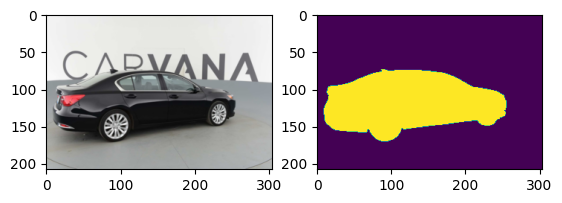

In [9]:
img, mask = segmentationDataset[11]
display_images(img, mask)

Build the UNET model

In [10]:
import torch
import torch.nn as nn

In [11]:
class DoubleConv(nn.Module):
    """ A double convolution layer in the Unet architecture.

    A series of two convolution layers with batch normalization followed by
    ReLU activation. Default kernel, padding, and stride result in a 'same'
    convolution, with different number of channels.

    Args:
        in_chan (int): The number input channels.
        out_chan (int): The number of output channels.
        kernel_size (int, optional): The size of the convolution kernel.
        stride (int, optional): The stride of the convolution kernel.
        padding (int, optional): The padding of the convolution kernel.

    Attributes:
        conv1 (nn.Conv2d): The first convolution layer.
        conv2 (nn.Conv2d): The second convolution layer.
        batchnorm1 (nn.BatchNorm2d): The first batch normalization layer.
        batchnorm2 (nn.BatchNorm2d): The second batch normalization layer.
        relu1 (nn.ReLU): The first ReLU activation layer.
        relu2 (nn.ReLU): The second ReLU activation layer.
    """

    def __init__(
        self,
        in_chan: int,
        out_chan: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 1
    ) -> None:

        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(
            in_chan,
            out_chan,
            kernel_size,
            stride=stride,
            padding=padding
        )
        self.batchnorm1 = nn.BatchNorm2d(out_chan)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_chan,
            out_chan,
            kernel_size,
            stride=stride,
            padding=padding
        )
        self.batchnorm2 = nn.BatchNorm2d(out_chan)
        self. relu2 = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward pass of DoubleConv class

        The forward pass of the DoubleConv class. This passes the input tensor
        through two rounds of Conv2d, batch normalization, and a ReLU
        activation.

        Args:
            x (torch.Tensor): An input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)

        return x


class DownwardLayers(nn.Module):
    """ The downward portion of UNET architecture

    The downward portion of the UNET architecture. This is a series of
    DoubleConv layers followed by max-pooling layer with decreasing img
    size and increasing number of channels.

    Args:
        channels (list[int]): List of channels for each layer in contracting
            portion.

    Attributes:
        downward_layers (nn.ModuleList): A list of DoubleConv blocks followed
            by max-pooling layers.

    """

    def __init__(self, channels: list[int]) -> None:
        super(DownwardLayers, self).__init__()
        self.downward_layers = nn.ModuleList()

        # Loop over all except last channel value
        for i in range(len(channels)-1):
            self.downward_layers.append(
                DoubleConv(channels[i], channels[i+1])
            )

            # Add MaxPool2d to all but last layer
            if i < (len(channels)-2):
                self.downward_layers.append(
                    nn.MaxPool2d(kernel_size=2)
                )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        """ Forward pass of the downward layers

        Forward pass of the downward layers of the UNET architecture. This
        will also return the output list of tensors from each DoubleConv
        block that is used in concatenation with the upward portion
        of the UNET architecture.

        Args:
            x (torch.Tensor): An input tensor representing image.

        Returns:
            list[torch.Tensor]: A list of the output tensors from each
                DoubleConv block.
        """
        outputs = []
        for step in self.downward_layers:
            x = step(x)

            if isinstance(step, DoubleConv):
                outputs.append(x)

        return outputs


class UpwardLayers(nn.Module):
    """ The upward portion of the UNET architecture

    The upward portion of the UNET architecture. This is a series of
    up-convolutions and concatenations with corresponding layer of the
    downward portion, followed by DoubleConv.

    Args:
        channels (list[int]): List of channels for each layer in the
            expanding portion.

    Attributes:
        upward_layers (nn.ModuleList): A list of up-convolution blocks.

    """

    def __init__(self, channels: list[int]) -> None:
        super(UpwardLayers, self).__init__()
        self.upward_layers = nn.ModuleList()

        for i in range(len(channels)-1):
            self.upward_layers.append(
                nn.ConvTranspose2d(
                    channels[i], channels[i+1], 2, 2
                )
            )

            self.upward_layers.append(
                DoubleConv(
                    channels[i], channels[i+1]
                )
            )

    def forward(self, x: torch.Tensor,
                downward_features: list[torch.Tensor]) -> torch.Tensor:
        """ forward pass for the upward portion of UNET

        Args:
            x (torch.Tensor): An input tensor.
            downward_features (list[torch.Tensor]): List of tensor features
                from the downward portion.

        Returns:
            torch.Tensor: Output feature tensor.
        """

        for i, step in enumerate(self.upward_layers):
            # concat feature from contract layer of DoubleConv
            if isinstance(step, DoubleConv):
                # tensor size batch,channel,H,W -> concat along chan
                x = torch.cat([downward_features[i//2], x], dim=1)

            # Apply the step
            x = step(x)

        return x


class UNET(nn.Module):
    """UNET Architecture model

    Args:
        out_channels (int): the number of final output channels.
        channels (list[int]): A list of channels for the convolutions
            at each layer.

    Attributes:
        downward (DownwardLayers): The downward layers of UNET.
        upward (UpwardLayers): The upward layers of UNET.
        output (nn.Conv2d): The final layer.

    Example:
        >>> model = UNET(channels=[3, 64, 128, 256, 512], out_channels = 1)
    """

    def __init__(
            self,
            channels: list[int],
            out_channels: int
    ) -> None:
        super(UNET, self).__init__()
        self.downward = DownwardLayers(channels=channels)
        # Need to reverse order and omit last
        self.upward = UpwardLayers(channels=channels[::-1][:-1])
        self.output = nn.Conv2d(
            channels[1], out_channels=out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward pass for UNET architecture

        Args:
            x (torch.Tensor): An input tensor.

        """
        # reverse order to pass into expanding layer
        downward_features = self.downward(x)[::-1]
        x = self.upward(downward_features[0], downward_features[1:])
        x = self.output(x)

        return x


In [12]:
# simple model test
channel_list = [3, 64, 128, 256, 512, 1024]
out_channels = 1
test_model = UNET(channels=channel_list, out_channels=out_channels)

in_tensor = torch.randn(3, 3, 256, 256)
out = test_model(in_tensor)

# should be 3,1,256,256
print(out.shape)

torch.Size([3, 1, 256, 256])


In [13]:
from tqdm.auto import tqdm

model = UNET(channels=LAYER_CHANNELS, out_channels=OUT_CHANNELS)
model.to(DEVICE)

UNET(
  (downward): DownwardLayers(
    (downward_layers): ModuleList(
      (0): DoubleConv(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DoubleConv(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm2): BatchNorm2d(128, e

In [14]:
def accuracy_fcn(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Simple accuracy function for unet

    NOTE: Accuracy should eventually be replaced by something
        like IOU or dice.
    Args:
        preds (torch.Tensor): Prediction outputs from model of
            shape (batch_size, img_height, img_width).
        targets (torch.Tensor): Target lables of same shape preds.

    Returns:
        torch.Tensor: accurcy of predictions.
    """
    pred_label = (torch.sigmoid(preds) > 0.5).float()
    return torch.mean((pred_label == targets).float())


def train_step(model: torch.nn.Module,
               dataloader: DataLoader,
               loss_fcn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: Optional[str] = str()) -> tuple[float, float]:
    """Train a pytorch model for one epoch.

    Args:
        model (torch.nn.Module): PyTorch model to be trained.
        dataloader (DataLoader): a DataLoader object containing train
            dataset.
        loss_fcn (torch.nn.Module): A loss function to be minimized
        optimizer (torch.optim.Optimizer): A optimizer to minimize
            loss_fcn
        device (str, optional): string defining device to load on
    Returns:
        tuple[float, float]: return performance values in the form
            (train_loss, train_acc).
    """
    model.train()

    train_loss, train_acc = 0.0, 0.0

    for imgs, masks in tqdm(dataloader):
        # optionally, load to device
        if device:
            imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)

        loss = loss_fcn(preds, masks)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += accuracy_fcn(preds, masks).item()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: DataLoader,
              losss_fcn: torch.nn.Module,
              device: Optional[str] = str()) -> tuple[float, float]:
    """ Perform testing over a single epoch

    Args:
        model (torch.nn.Module): PyTorch model to be evaluated.
        dataloader (DataLoader): DataLoader object containing test
            dataset.
        losss_fcn (torch.nn.Module): A loss function to calculate
            loss on test dataset.
        device (str, optional): string defining device to load on

    Returns:
        tuple[float, float]: return performance values in the form
            (test_loss, test_acc).
    """

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for imgs, masks in tqdm(dataloader):
            # optionally, load to device
            if device:
                imgs, masks = imgs.to(device), masks.to(device)

            preds = model(imgs)

            test_loss += loss_fn(preds, masks).item()
            test_acc += accuracy_fcn(preds, masks).item()

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


def train_loop(model: torch.nn.Module,
               train_dataloader: DataLoader,
               test_dataloader: DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fcn: torch.nn.Module,
               epochs: int = 10) -> None:

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fcn=loss_fcn,
                                           optimizer=optimizer,
                                           device=DEVICE)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        losss_fcn=loss_fcn,
                                        device=DEVICE)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loop(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fcn=loss_fn,
            epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2696 | train_acc: 0.9712 | test_loss: 0.2028 | test_acc: 0.9891


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1716 | train_acc: 0.9929 | test_loss: 0.1477 | test_acc: 0.9939


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1318 | train_acc: 0.9945 | test_loss: 0.1159 | test_acc: 0.9950


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1039 | train_acc: 0.9955 | test_loss: 0.0932 | test_acc: 0.9954


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0841 | train_acc: 0.9957 | test_loss: 0.0756 | test_acc: 0.9961


  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(),'./drive/MyDrive/mymodel.pth')